### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'patient_sex'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 5e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


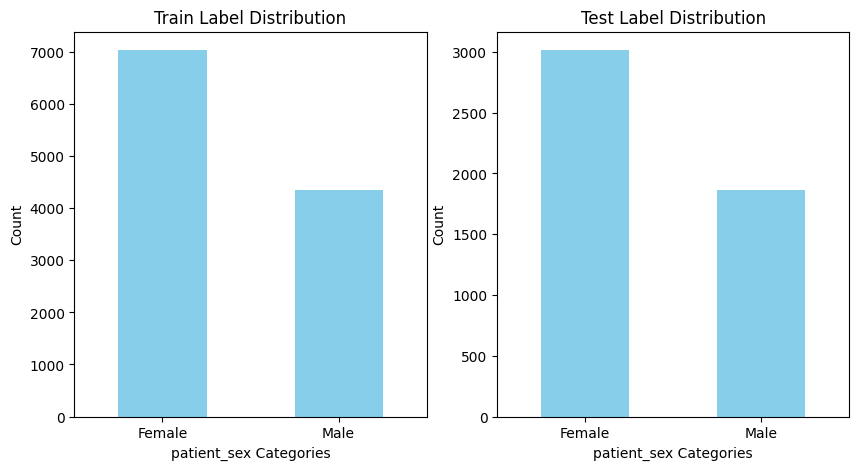

Getting validation set...
Train data shape: (10247, 35)
Test data shape: (1139, 35)


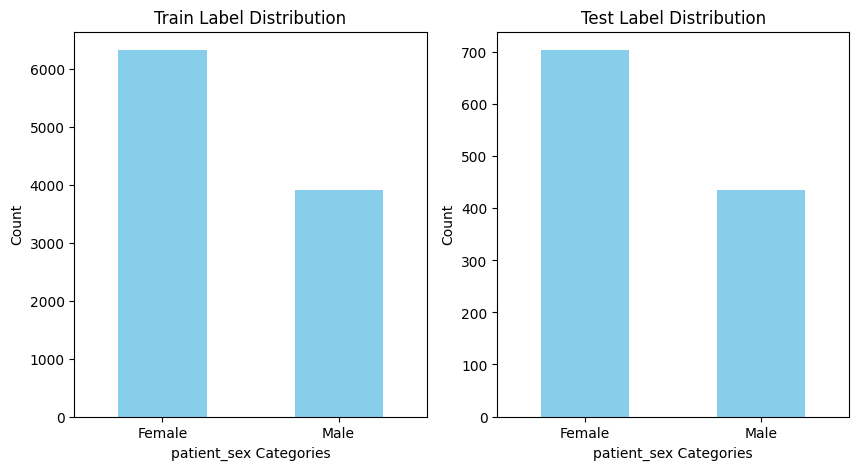

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_train, df_val = split_data(df_train, LABEL, 0.10)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

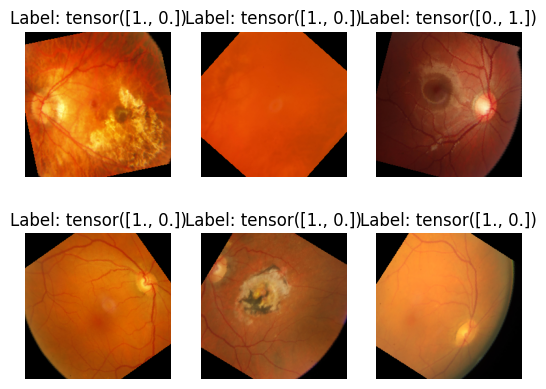

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone='convnextv2_binary_{LABEL}')

100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 1, Train Loss: 0.7183887201612713, Val Loss: 0.7644366973804103, F1 Score: 0.5028640242262481


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 2, Train Loss: 0.6828482806124665, Val Loss: 0.6967218518257141, F1 Score: 0.5922950311447364


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 3, Train Loss: 0.664074635542871, Val Loss: 0.6416556218432056, F1 Score: 0.6323235696339408


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 4, Train Loss: 0.6347525228111309, Val Loss: 0.6417479568885432, F1 Score: 0.6804092184495097


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 5, Train Loss: 0.6155541550350635, Val Loss: 0.6151215698983934, F1 Score: 0.6558193333286724


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 6, Train Loss: 0.5909814762529828, Val Loss: 0.5898724645376205, F1 Score: 0.6819028113945261


100%|██████████| 72/72 [00:21<00:00,  3.41it/s]


Epoch 7, Train Loss: 0.5747653963785275, Val Loss: 0.6399701784054438, F1 Score: 0.659623773278652


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 8, Train Loss: 0.5578903901781567, Val Loss: 0.5575709566473961, F1 Score: 0.7303860797836701


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 9, Train Loss: 0.5411718128809877, Val Loss: 0.6754367608163092, F1 Score: 0.624610076127994


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 10, Train Loss: 0.5225491609755619, Val Loss: 0.5725878849625587, F1 Score: 0.7291412873178376


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 11, Train Loss: 0.5097397824345439, Val Loss: 0.6405050423410203, F1 Score: 0.6299656526043752


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 12, Train Loss: 0.5101138382638672, Val Loss: 0.6099143653280206, F1 Score: 0.6478053911170024


100%|██████████| 72/72 [00:20<00:00,  3.43it/s]


Epoch 13, Train Loss: 0.49443038679694234, Val Loss: 0.626559437563022, F1 Score: 0.6836989725076368


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 14, Train Loss: 0.48434838213247366, Val Loss: 0.5390313764413198, F1 Score: 0.7594054238430464


100%|██████████| 72/72 [00:21<00:00,  3.42it/s]


Epoch 15, Train Loss: 0.4729174823033828, Val Loss: 0.5134900889048973, F1 Score: 0.7550273197977104


100%|██████████| 72/72 [00:21<00:00,  3.43it/s]


Epoch 16, Train Loss: 0.46063131670498064, Val Loss: 0.6546157975163724, F1 Score: 0.6373710272689619


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 17, Train Loss: 0.4526404704485966, Val Loss: 0.568234550456206, F1 Score: 0.7398802558747843


100%|██████████| 72/72 [00:20<00:00,  3.54it/s]


Epoch 18, Train Loss: 0.4295930366341298, Val Loss: 0.5376166705456045, F1 Score: 0.7472876941380753


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 19, Train Loss: 0.43224148652203925, Val Loss: 0.5800008335047298, F1 Score: 0.7176655526347077


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 20, Train Loss: 0.41554854746309344, Val Loss: 0.5763857588171959, F1 Score: 0.7241774130979111


100%|██████████| 72/72 [00:20<00:00,  3.58it/s]


Epoch 21, Train Loss: 0.4105315095455896, Val Loss: 0.522805197785298, F1 Score: 0.7362490054381401
Early stopping triggered.


### Test

100%|██████████| 305/305 [01:23<00:00,  3.64it/s]


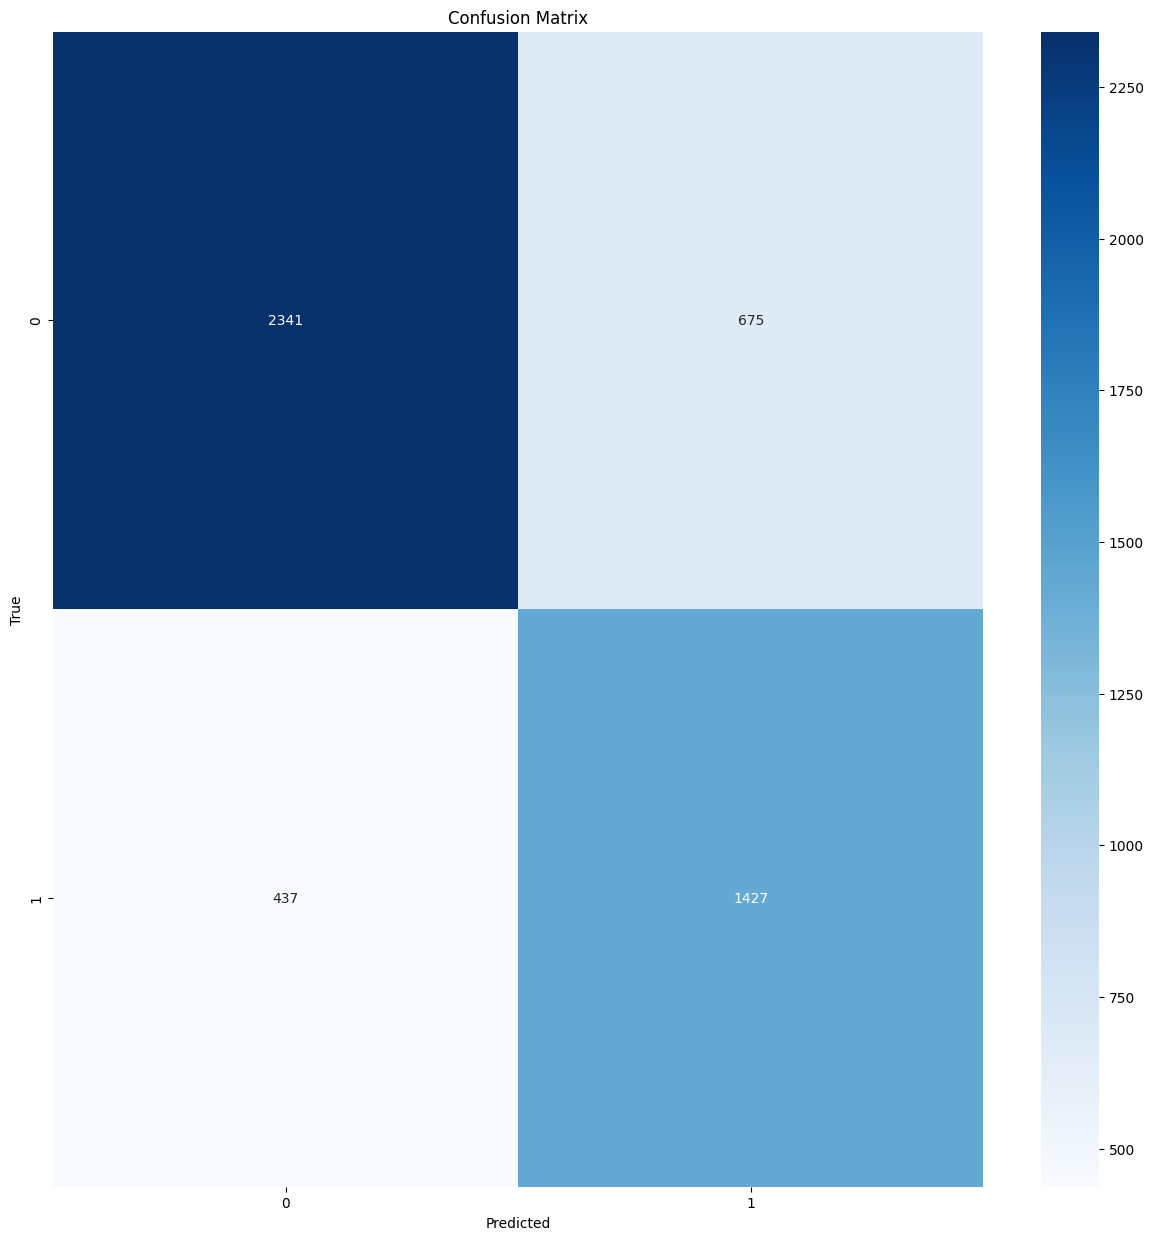

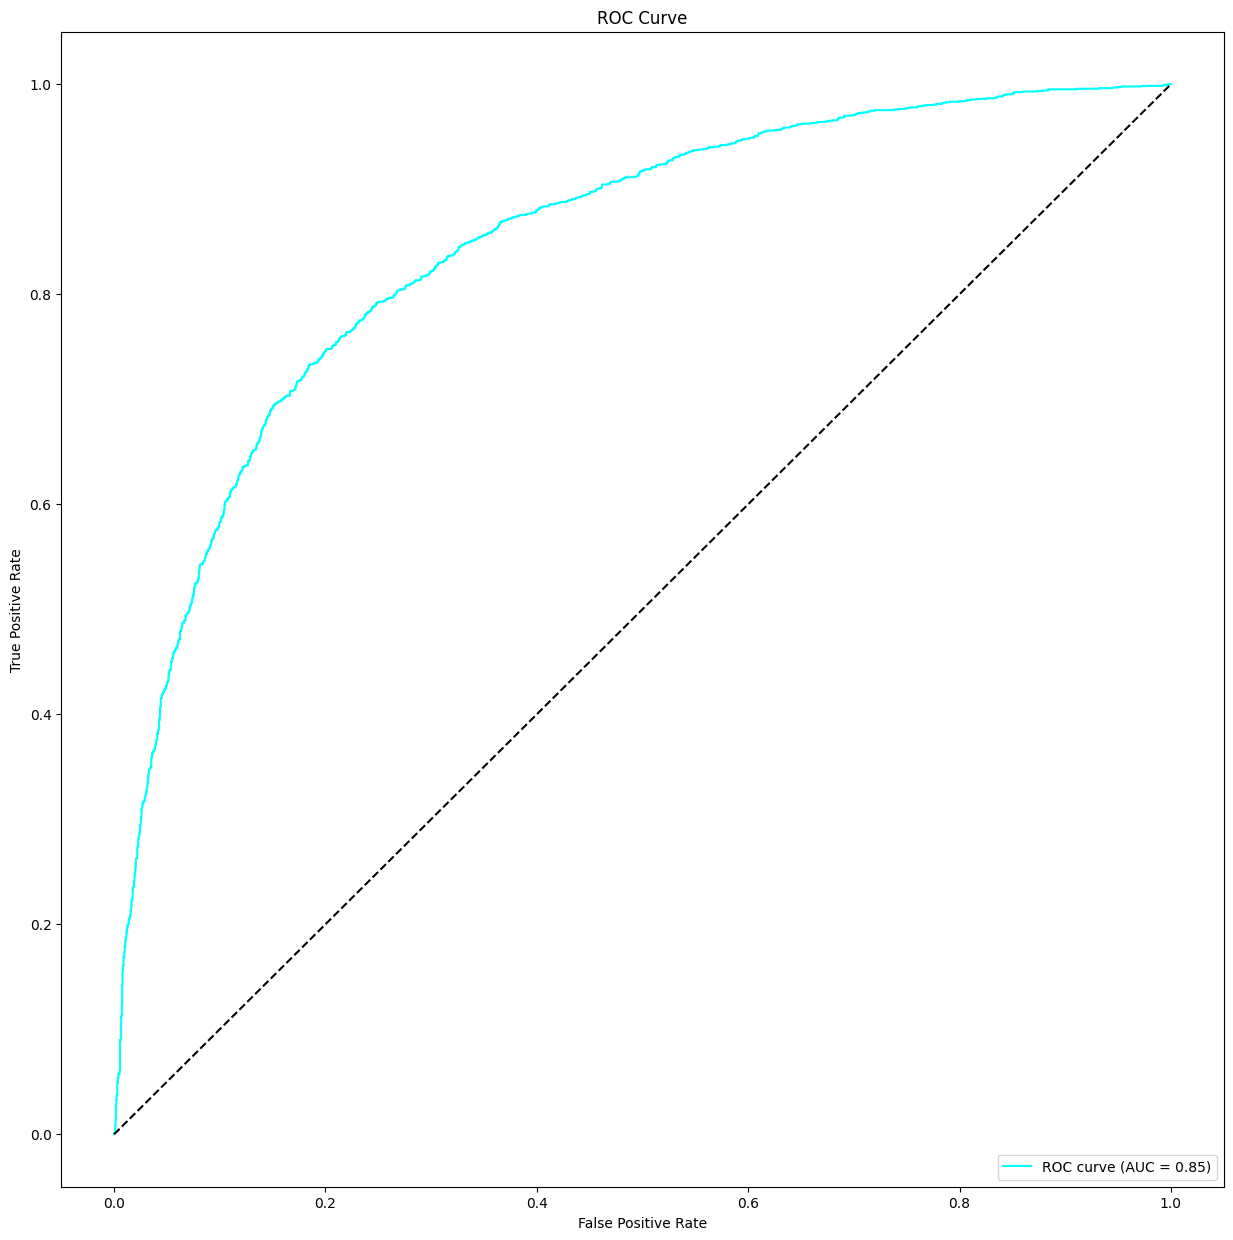

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3016
           1       0.68      0.77      0.72      1864

    accuracy                           0.77      4880
   macro avg       0.76      0.77      0.76      4880
weighted avg       0.78      0.77      0.77      4880

##################################################  Saliency Maps  ##################################################

Class 0:


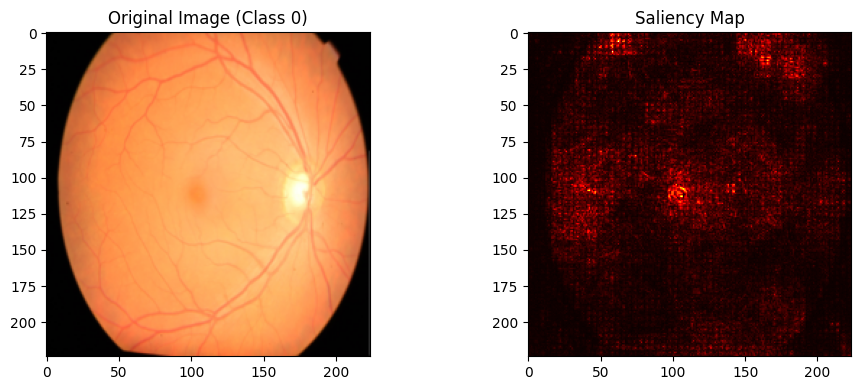

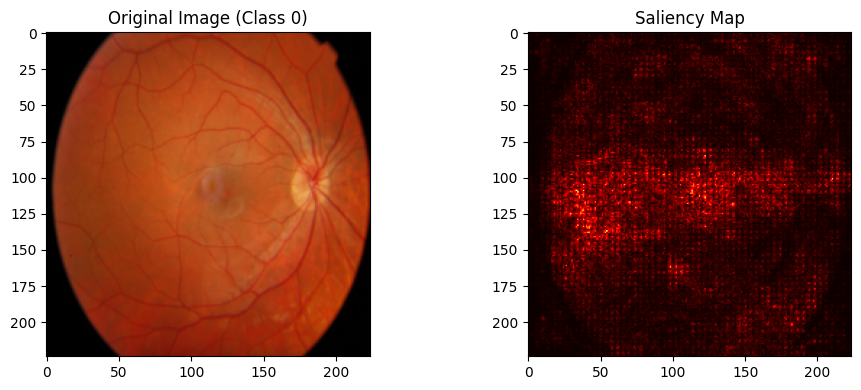

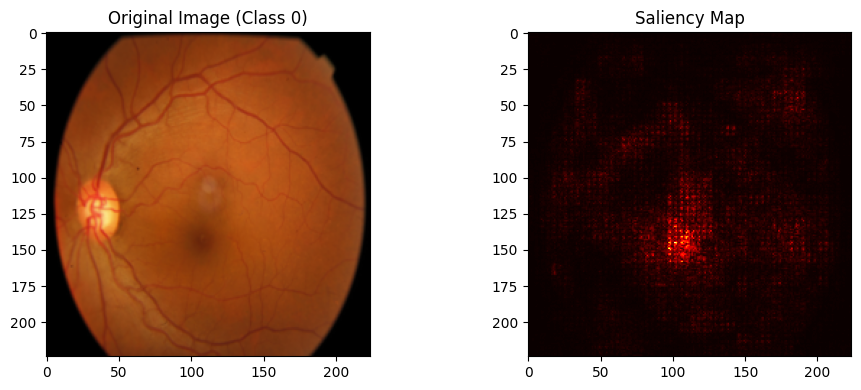

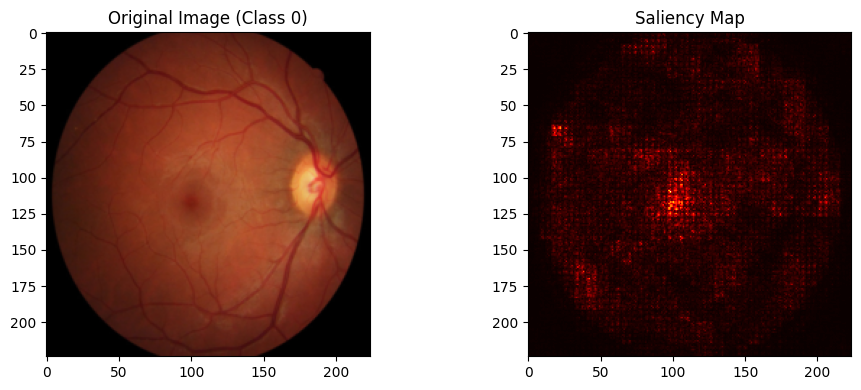

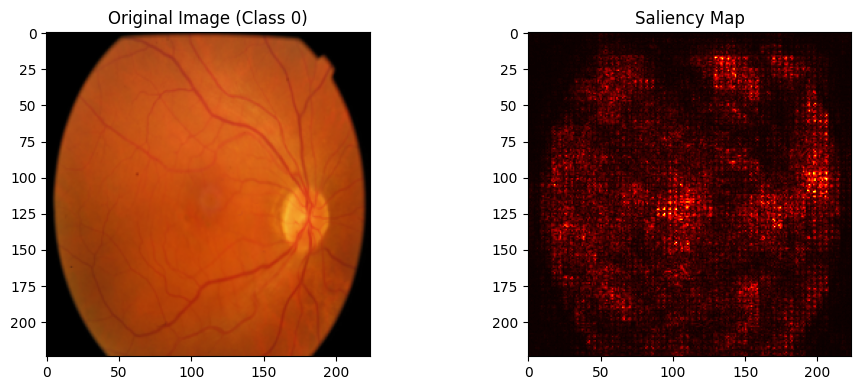

Class 1:


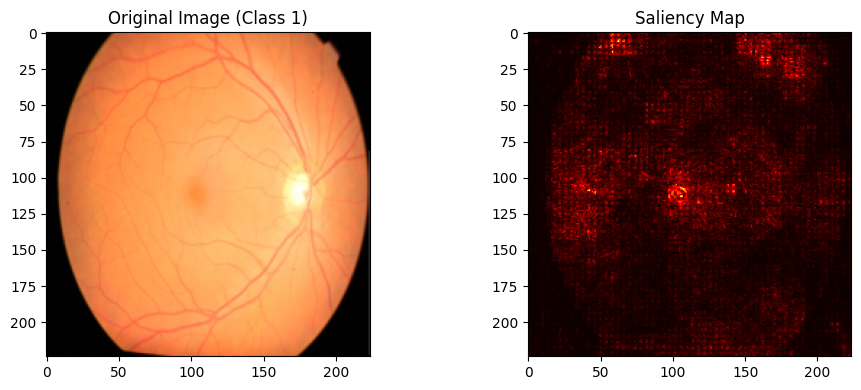

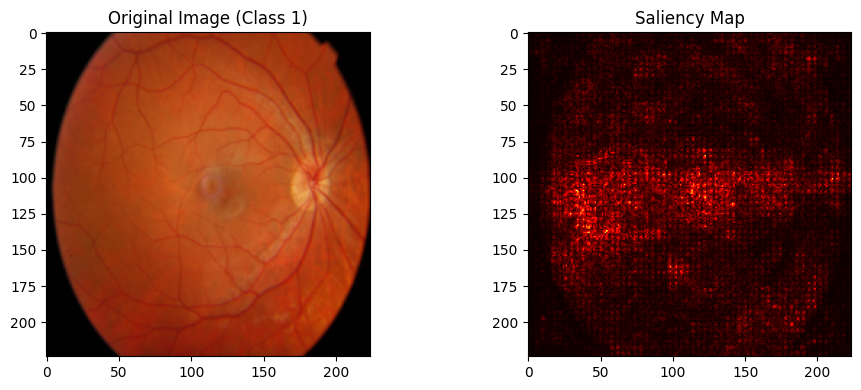

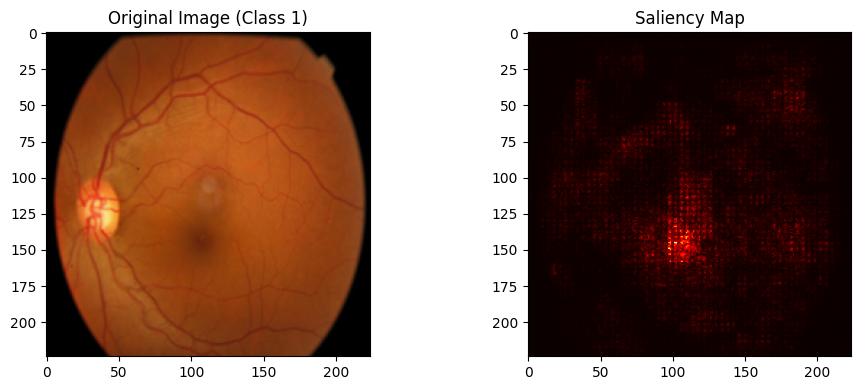

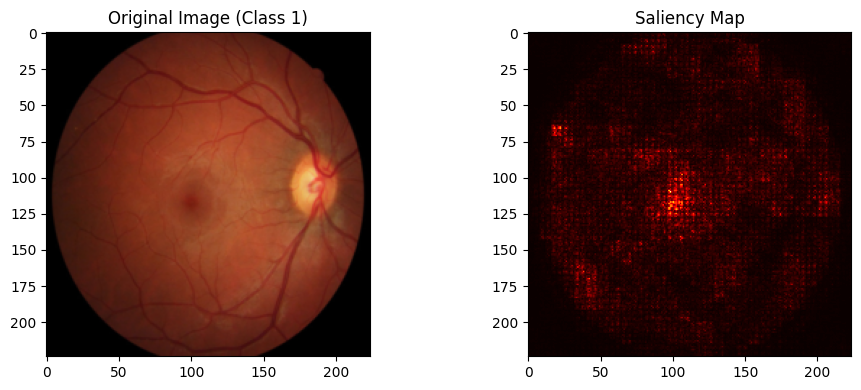

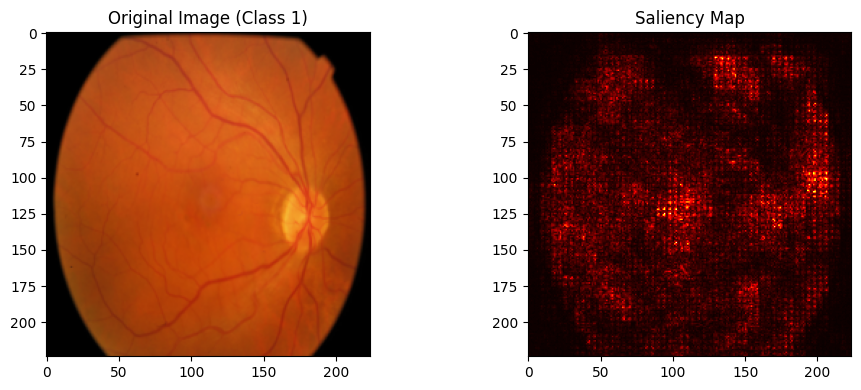

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 269/269 [01:14<00:00,  3.59it/s]


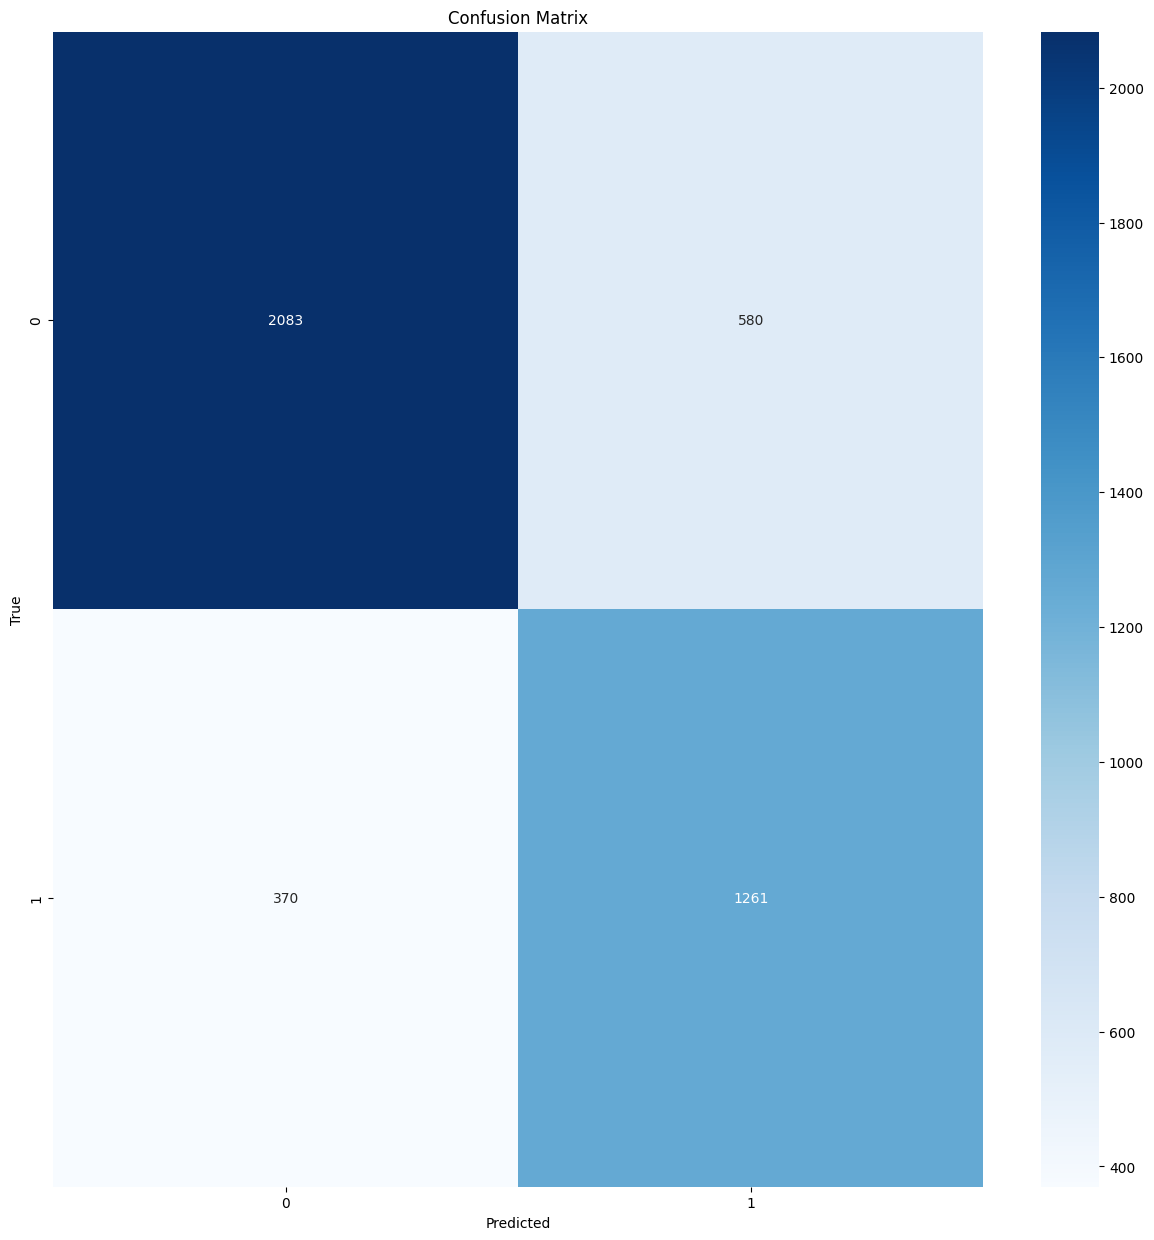

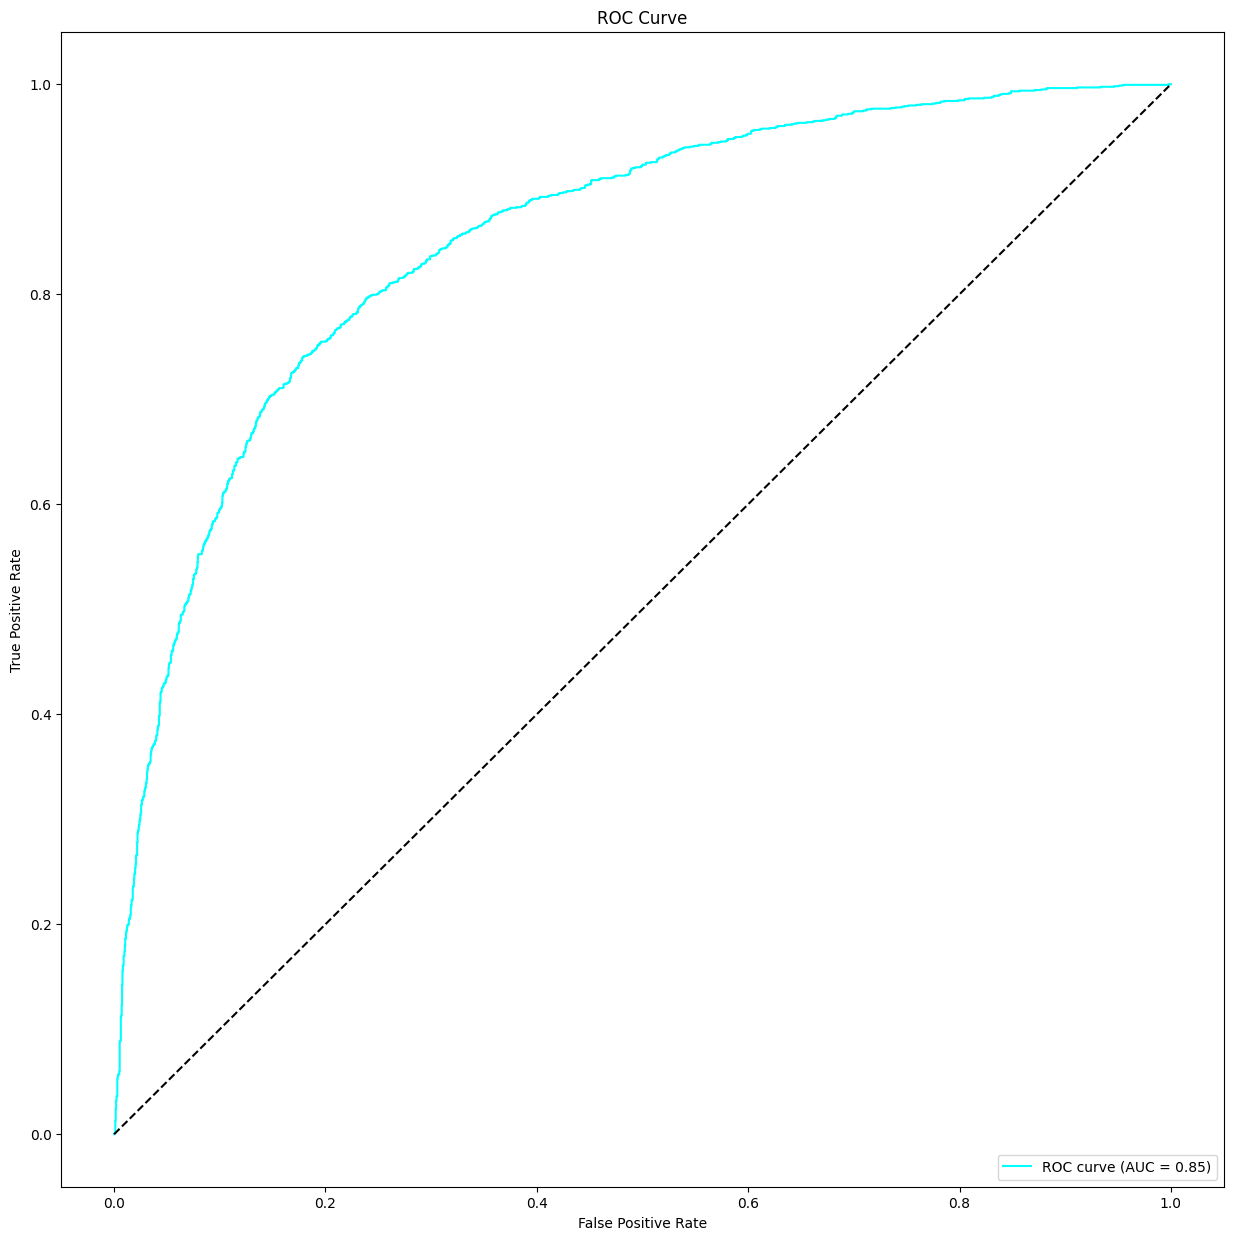

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2663
           1       0.68      0.77      0.73      1631

    accuracy                           0.78      4294
   macro avg       0.77      0.78      0.77      4294
weighted avg       0.79      0.78      0.78      4294

##################################################  Saliency Maps  ##################################################

Class 0:


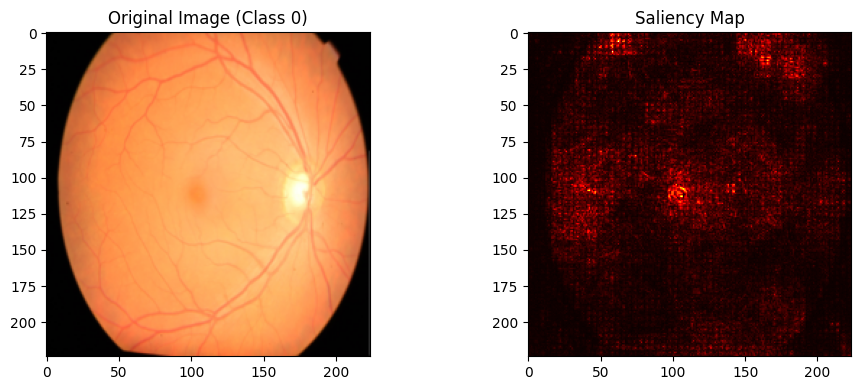

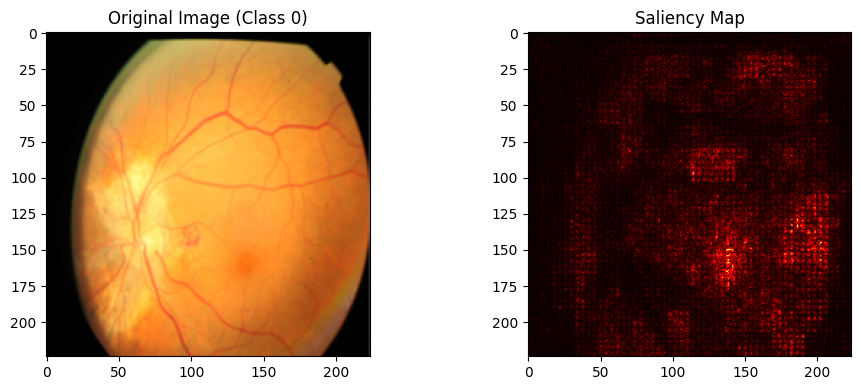

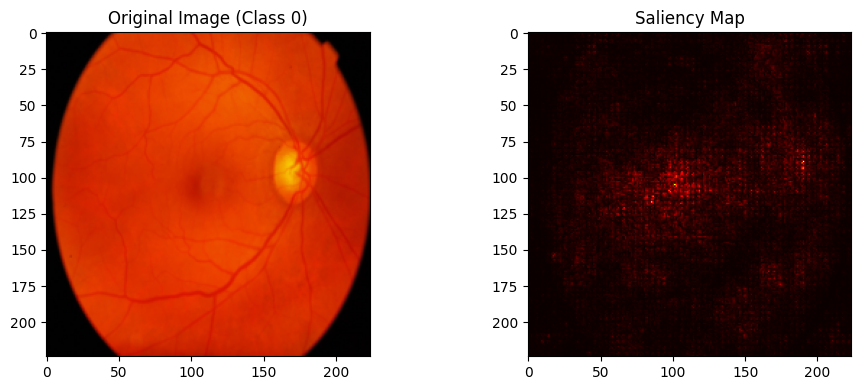

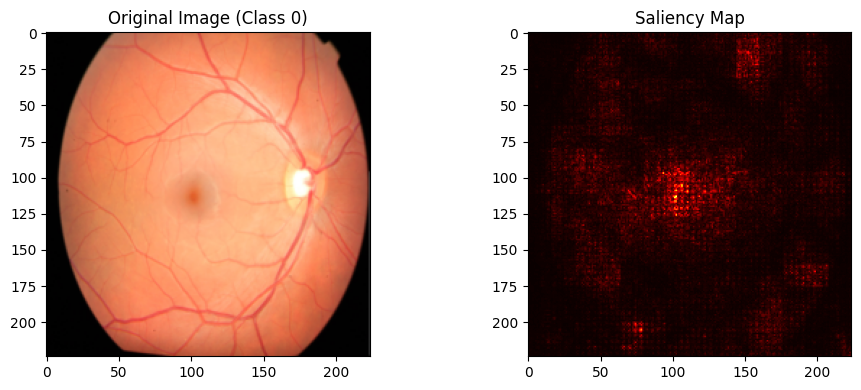

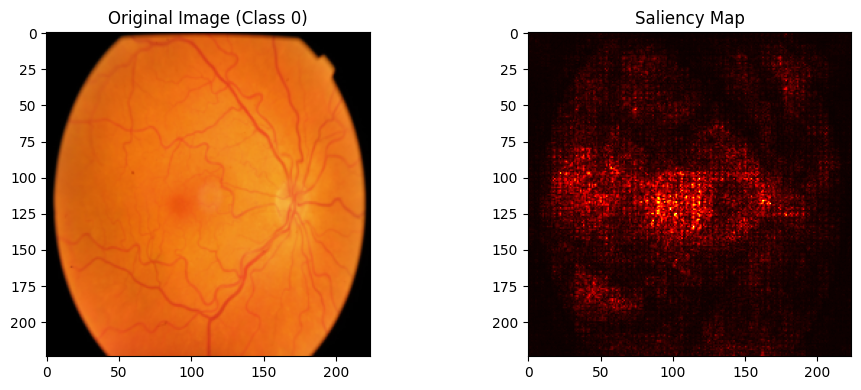

Class 1:


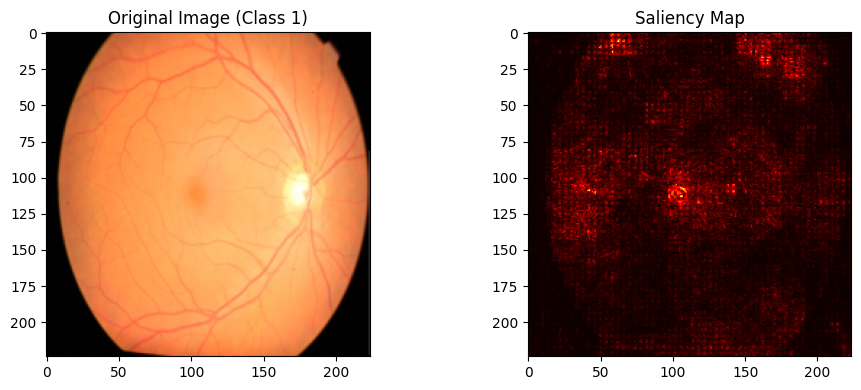

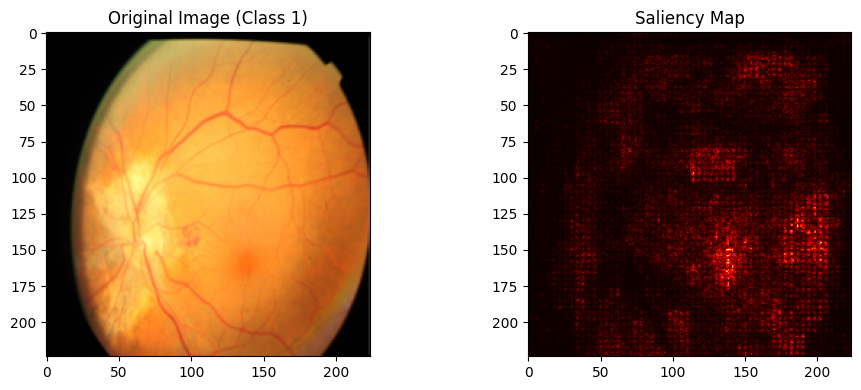

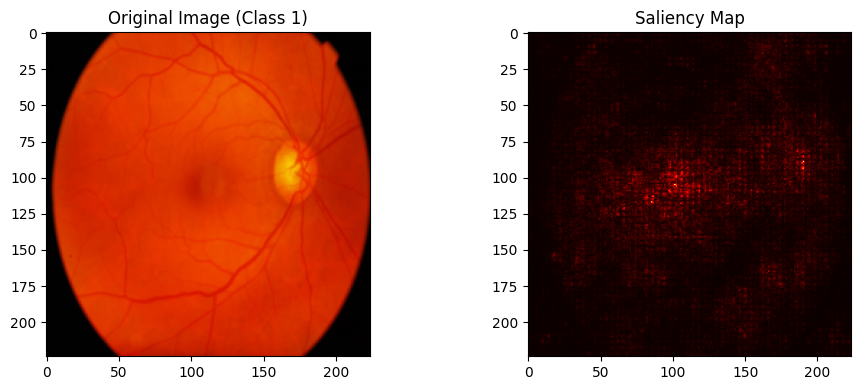

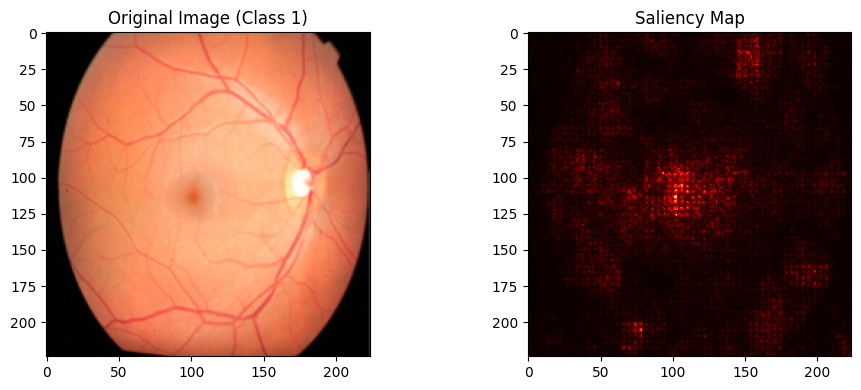

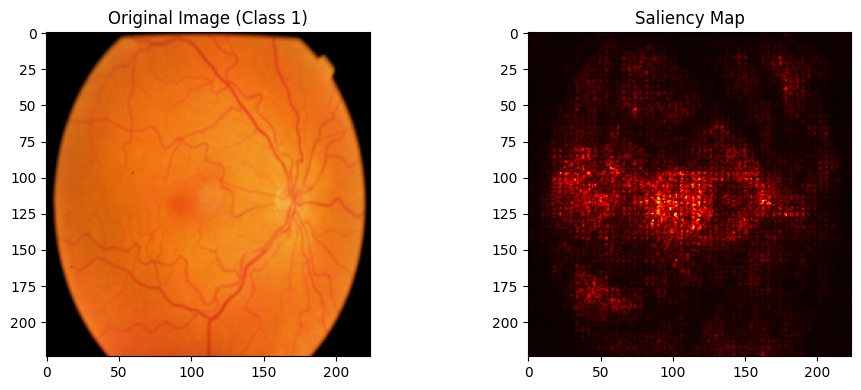

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


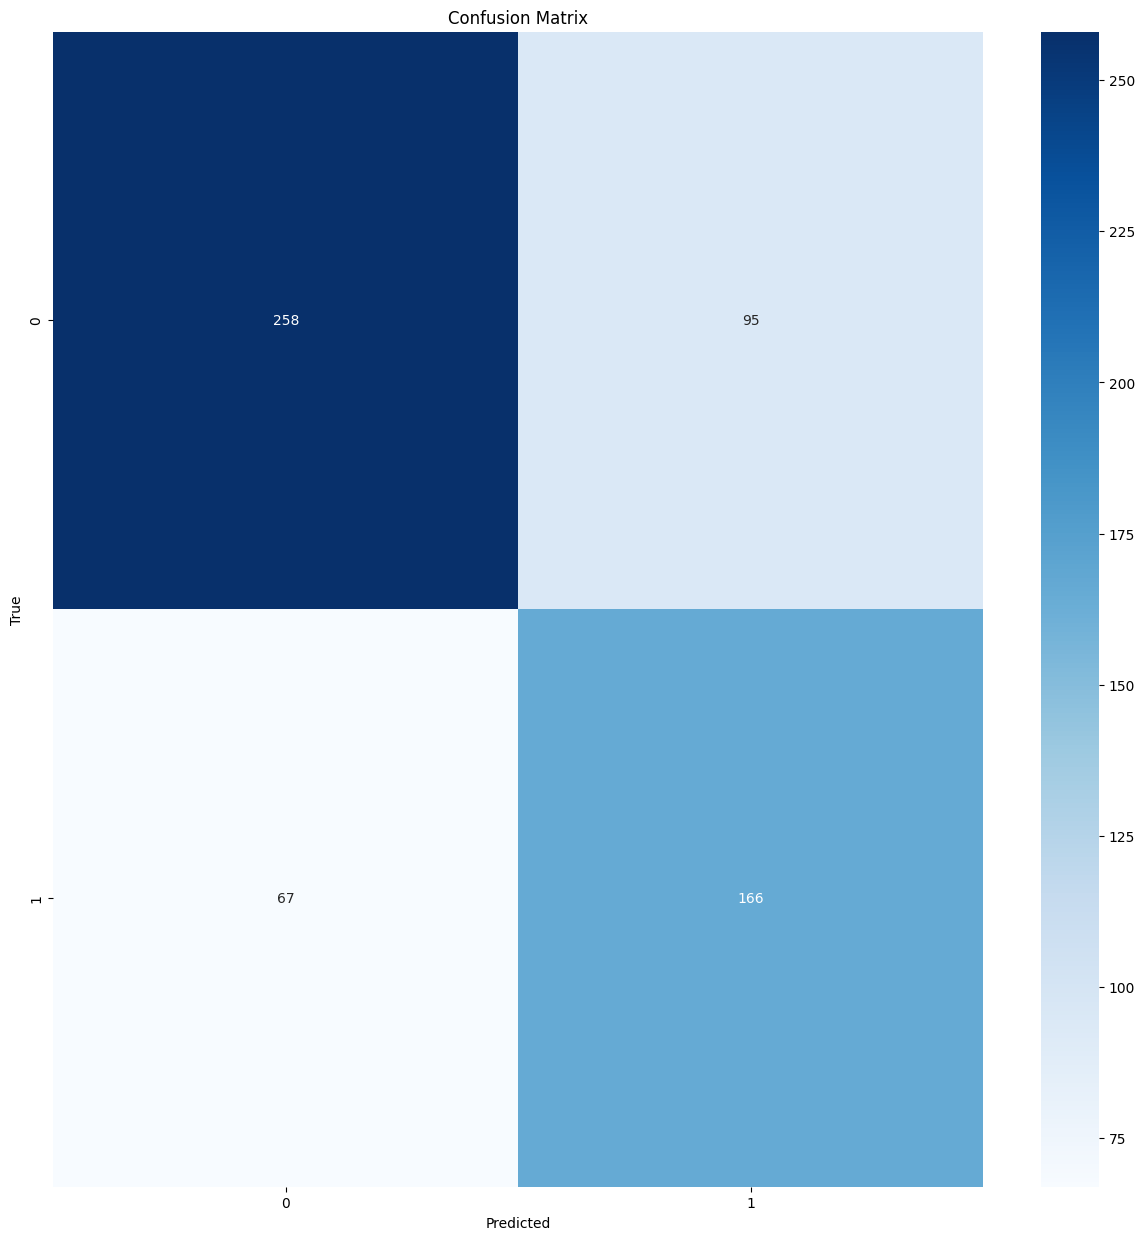

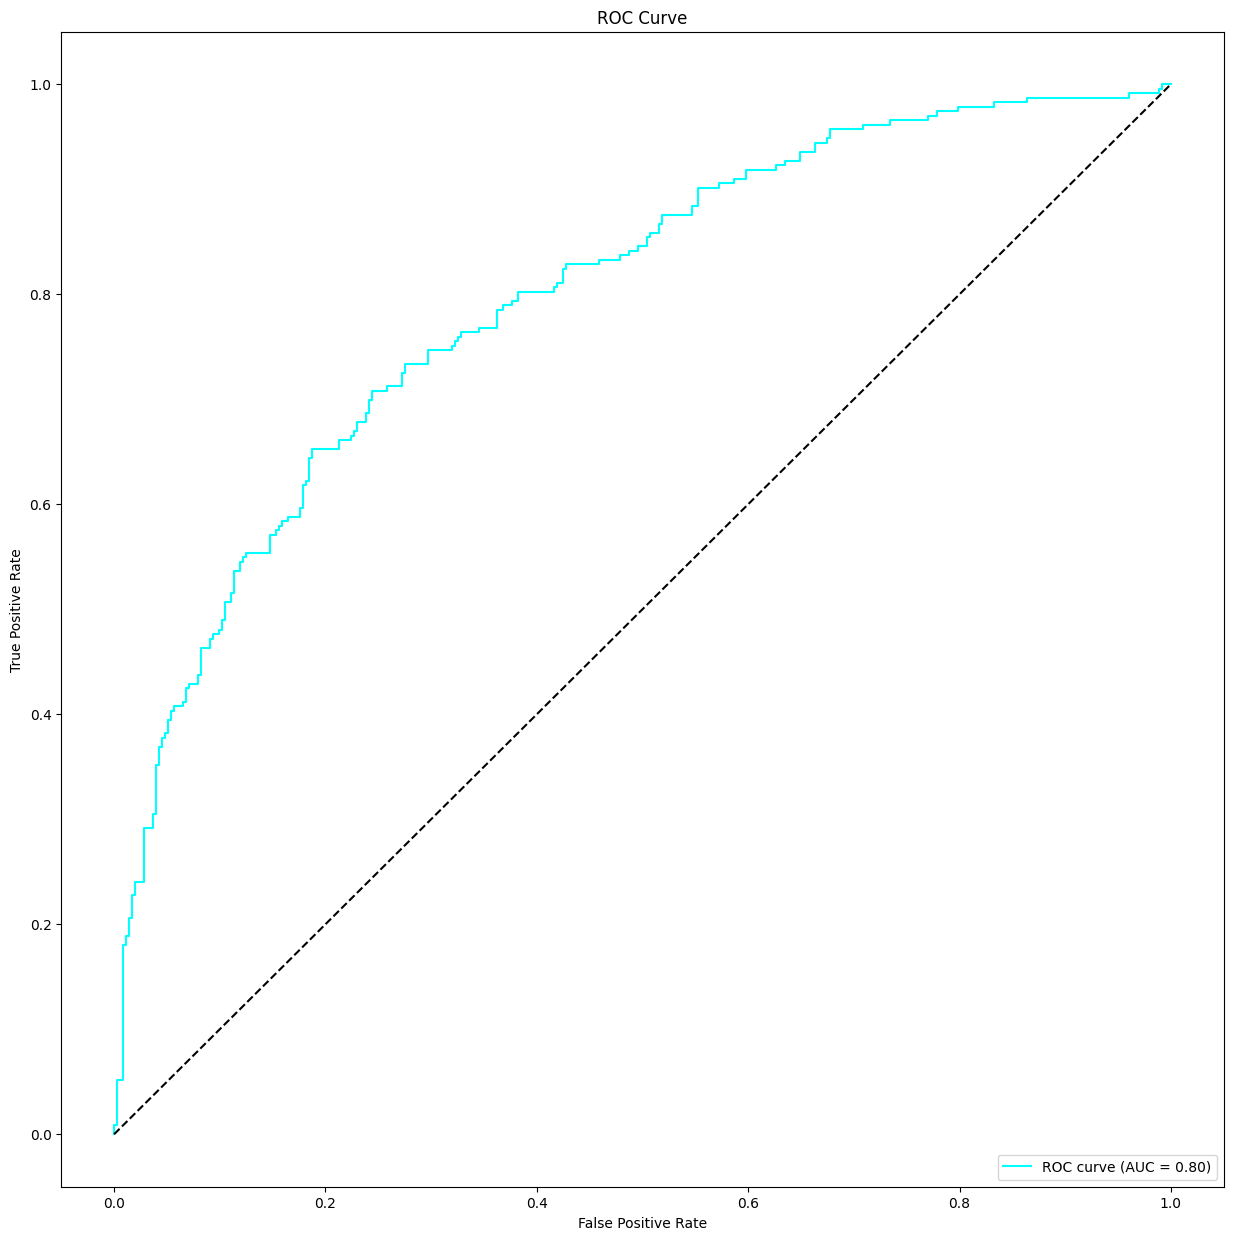

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       353
           1       0.64      0.71      0.67       233

    accuracy                           0.72       586
   macro avg       0.71      0.72      0.72       586
weighted avg       0.73      0.72      0.73       586

##################################################  Saliency Maps  ##################################################

Class 0:


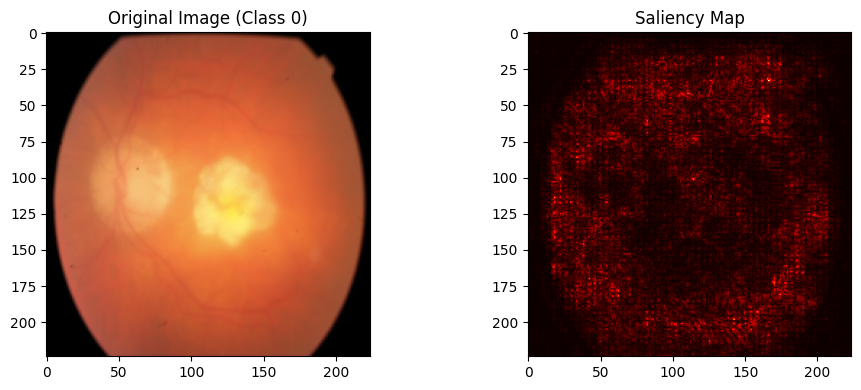

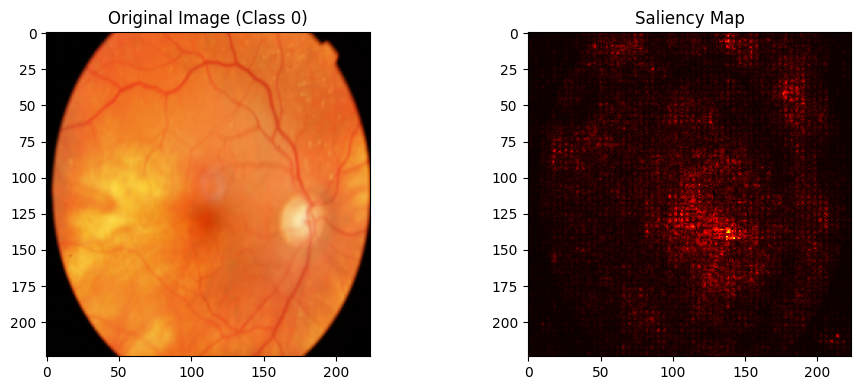

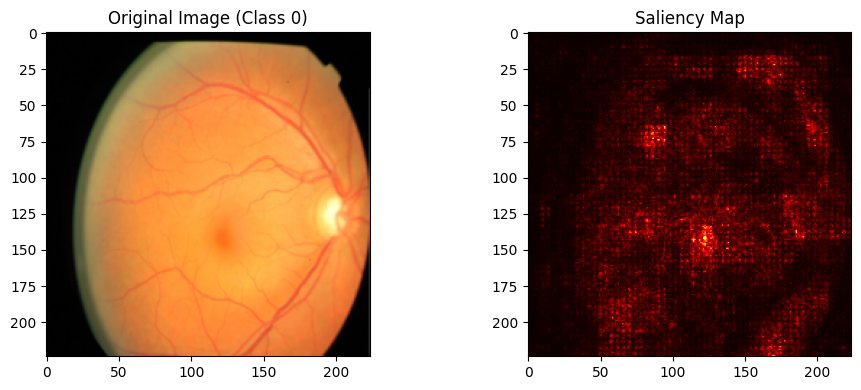

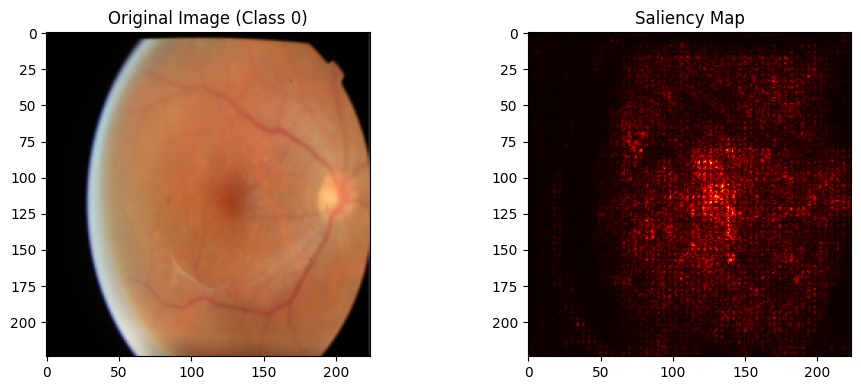

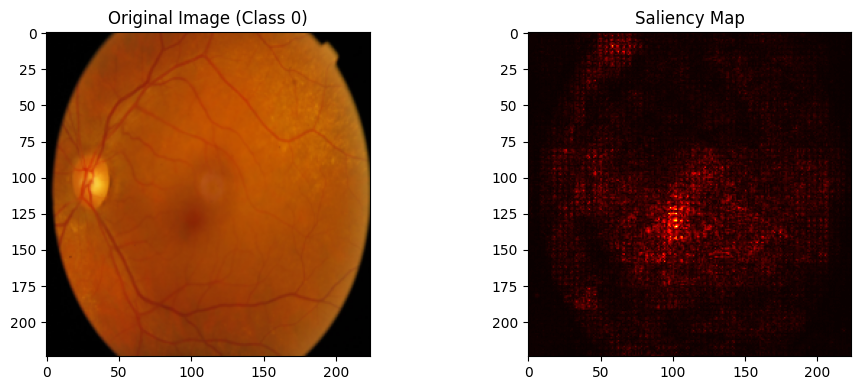

Class 1:


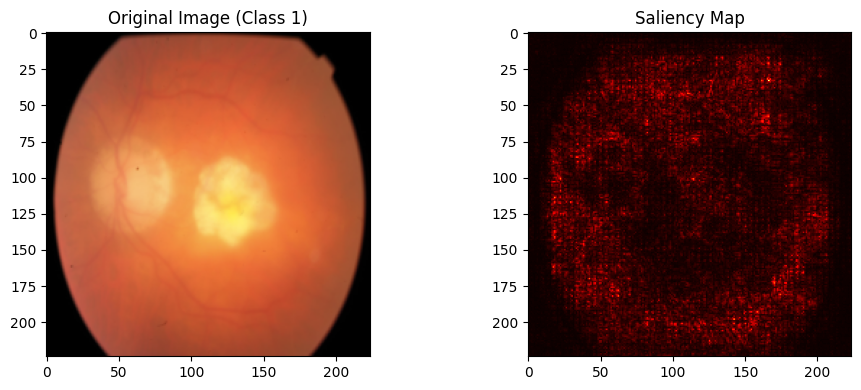

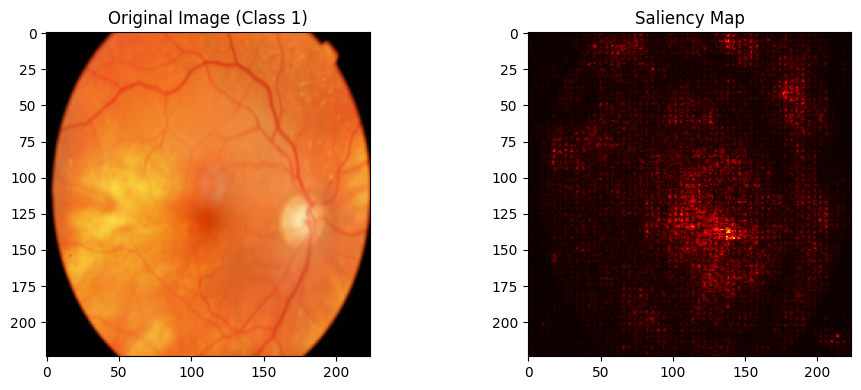

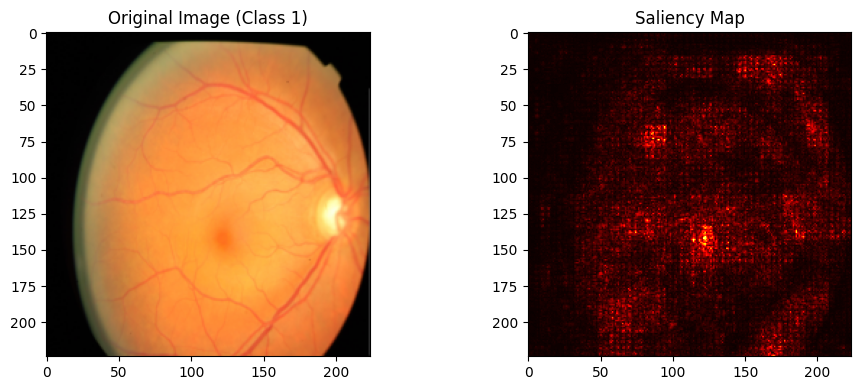

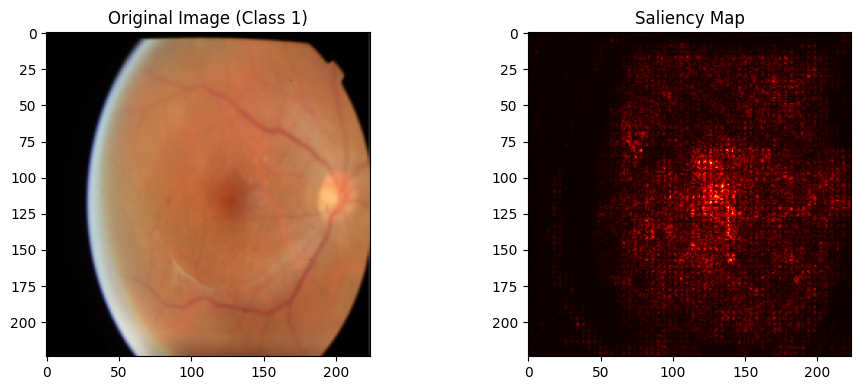

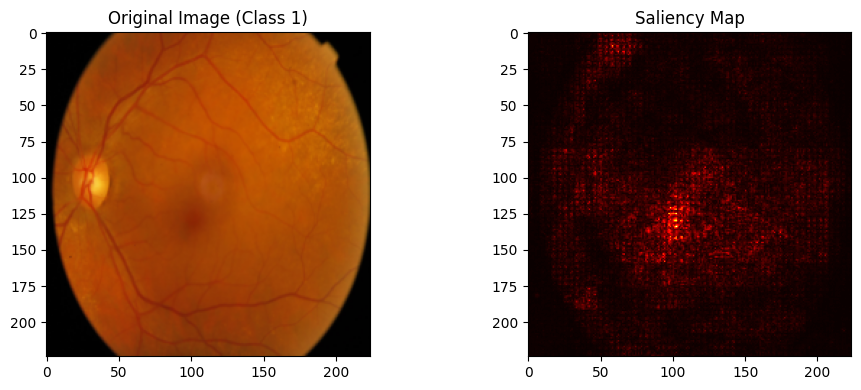

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)